In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D , Flatten , Dropout, Dense 
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import sys
import skimage.io
from skimage import color
from skimage.transform import resize
from skimage.feature import canny
import cv2
from keras.losses import categorical_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 224


##### Load Dataset

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

##### Image Preprocessing functions as in previous code

function to shorten gray images

In [3]:
def crop_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape != 0):
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1) 
        else:
            return img
        return img

function to crop images in a circle

In [4]:
def crop_image(img, sigmaX):   
    img = cv2.imread(img)
    img = crop_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    new_img = np.zeros((height, width), np.uint8)
    cv2.circle(new_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=new_img)
    img = crop_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

function to detect and display edges in the image

In [5]:
def edge_Detect(img):
    img = color.rgb2gray(img) 
    edges = canny(img) 
    return edges

##### Preprocessing the whole train dataset

In [6]:
def preProcessTrain(channel,train):
    train_image = []
    X =np.array([])
    if channel==1:
        for i in tqdm(range(train.shape[0])):
            path=f"../input/aptos2019-blindness-detection/train_images/{train['id_code'][i]}.png"
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224, 224))
#             img = crop_image(path,30)
#             img = edge_Detect(img)
            img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , 30) ,-4 ,128)
            img_array = img/255
            train_image.append(img_array)
        X = np.array(train_image)
        X = X.reshape(list(X.shape) + [1])
    else:
        for i in tqdm(range(train.shape[0])):
            img = image.load_img('../input/aptos2019-blindness-detection/train_images/'+train['id_code'][i]+'.png', target_size=(IMG_SIZE,IMG_SIZE,3), grayscale=False)
        #     img = circle_crop (img,30)
#             img = edge_Detect(img)
            img_array = image.img_to_array(img)
            img_array =img_array/255
            train_image.append(img_array)
        X = np.array(train_image)
    return X
    

##### data augmenter to increase the train data size

In [7]:
dataAugmenter = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True, 
        vertical_flip=False)

##### Function to plot accuracy and loss for training and testing set

In [21]:
def plot_results(result,epoch_range):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']
    loss = result.history['loss']
    val_loss = result.history['val_loss']

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epoch_range, acc, label='Training Accuracy')
    plt.plot(epoch_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epoch_range, loss, label='Training Loss')
    plt.plot(epoch_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Model 1 (Simple CNN Model single channel)

##### preprocessing the training dataset for model 1 (as 1 channel is required)

In [8]:
X = preProcessTrain(1,train)

100%|██████████| 3662/3662 [12:34<00:00,  4.85it/s]


In [11]:
Y=train['diagnosis'].values
Y = to_categorical(Y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2,stratify=Y)

In [13]:
dataAugmenter.fit(X_train)

In [10]:
#model 1
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(224,224,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [11]:
#computing model1 results
result1=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
92/92 [==============================] - 463s 5s/step - loss: 8.1413 - accuracy: 0.5942 - val_loss: 0.8029 - val_accuracy: 0.7067
Epoch 2/10
92/92 [==============================] - 467s 5s/step - loss: 0.7846 - accuracy: 0.7187 - val_loss: 0.8352 - val_accuracy: 0.7067
Epoch 3/10
92/92 [==============================] - 439s 5s/step - loss: 0.7471 - accuracy: 0.7298 - val_loss: 0.7865 - val_accuracy: 0.7121
Epoch 4/10
92/92 [==============================] - 456s 5s/step - loss: 0.7299 - accuracy: 0.7378 - val_loss: 0.7696 - val_accuracy: 0.7108
Epoch 5/10
92/92 [==============================] - 458s 5s/step - loss: 0.7265 - accuracy: 0.7270 - val_loss: 0.9351 - val_accuracy: 0.7080
Epoch 6/10
92/92 [==============================] - 464s 5s/step - loss: 0.6956 - accuracy: 0.7514 - val_loss: 0.7755 - val_accuracy: 0.7067
Epoch 7/10
92/92 [==============================] - 443s 5s/step - loss: 0.6680 - accuracy: 0.7541 - val_loss: 0.7782 - val_accuracy: 0.7217
Epoch 8/10
92

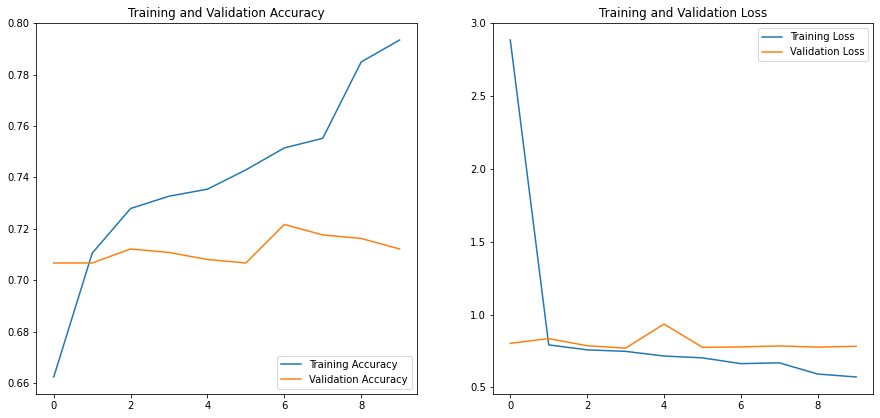

In [13]:
#plotting model1 accuracy 
plot_results(result1,range(10))

##### preprocessing data for model 2 and 3 (both uses 3 channels)

In [15]:
X = preProcessTrain(3,train) 

100%|██████████| 3662/3662 [11:17<00:00,  5.40it/s]


In [18]:
Y=train['diagnosis'].values
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2,stratify=Y)

In [19]:
#fitting dataset in data augmenter
dataAugmenter.fit(X_train)

### Model 2 (3 layer CNN model Keras Image Classification) first set of CONV => RELU => MAX POOL layers

In [16]:
# model 2
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
adam = Adam(lr=1e-3, decay=1e-3/ 15)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [20]:
#computing model 2 results
result2=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
92/92 [==============================] - 524s 6s/step - loss: 1.2296 - accuracy: 0.5218 - val_loss: 0.8445 - val_accuracy: 0.7121
Epoch 2/10
92/92 [==============================] - 561s 6s/step - loss: 0.8141 - accuracy: 0.7124 - val_loss: 0.8247 - val_accuracy: 0.7231
Epoch 3/10
92/92 [==============================] - 552s 6s/step - loss: 0.7783 - accuracy: 0.7203 - val_loss: 0.7825 - val_accuracy: 0.7149
Epoch 4/10
92/92 [==============================] - 558s 6s/step - loss: 0.7376 - accuracy: 0.7296 - val_loss: 0.7604 - val_accuracy: 0.7244
Epoch 5/10
92/92 [==============================] - 555s 6s/step - loss: 0.7460 - accuracy: 0.7340 - val_loss: 0.7725 - val_accuracy: 0.7135
Epoch 6/10
92/92 [==============================] - 553s 6s/step - loss: 0.7640 - accuracy: 0.7237 - val_loss: 0.7665 - val_accuracy: 0.7381
Epoch 7/10
92/92 [==============================] - 552s 6s/step - loss: 0.6642 - accuracy: 0.7473 - val_loss: 0.7553 - val_accuracy: 0.7285
Epoch 8/10
92

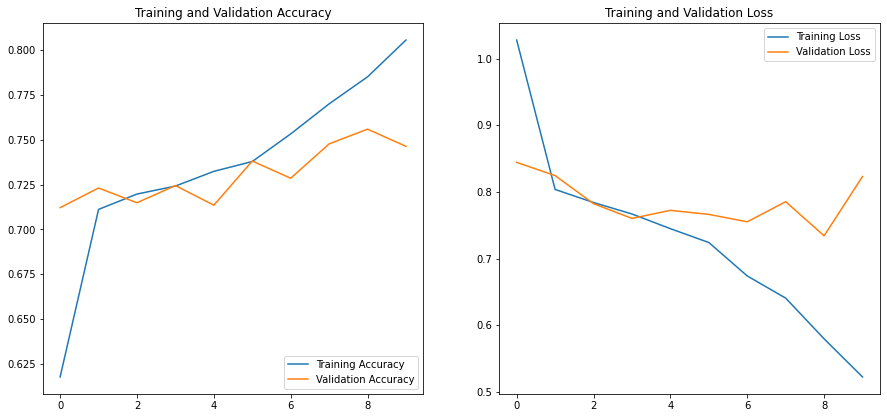

In [22]:
#plotting model 2 accuracy
plot_results(result2,range(10))

### Model 3 (Transfer Learning Model)

In [19]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), 
                                               include_top = False, 
                                               weights = "imagenet")
pretrained_model.trainable = False
model = tf.keras.Sequential([pretrained_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.25),
                                 tf.keras.layers.Dense(5, activation="softmax")                                     
                                ])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
#computing model 3 results
result3 = model.fit(X_train,y_train,epochs = 100 , validation_data = (X_test, y_test))

Epoch 1/100
92/92 [==============================] - 106s 1s/step - loss: 0.4382 - accuracy: 0.5569 - val_loss: 0.2701 - val_accuracy: 0.7040
Epoch 2/100
92/92 [==============================] - 96s 1s/step - loss: 0.2677 - accuracy: 0.7251 - val_loss: 0.2490 - val_accuracy: 0.7203
Epoch 3/100
92/92 [==============================] - 101s 1s/step - loss: 0.2435 - accuracy: 0.7578 - val_loss: 0.2368 - val_accuracy: 0.7353
Epoch 4/100
92/92 [==============================] - 94s 1s/step - loss: 0.2281 - accuracy: 0.7644 - val_loss: 0.2305 - val_accuracy: 0.7585
Epoch 5/100
92/92 [==============================] - 91s 989ms/step - loss: 0.2163 - accuracy: 0.7865 - val_loss: 0.2225 - val_accuracy: 0.7613
Epoch 6/100
92/92 [==============================] - 94s 1s/step - loss: 0.2166 - accuracy: 0.7780 - val_loss: 0.2274 - val_accuracy: 0.7640
Epoch 7/100
92/92 [==============================] - 96s 1s/step - loss: 0.2182 - accuracy: 0.7726 - val_loss: 0.2178 - val_accuracy: 0.7681
Epoch 8/

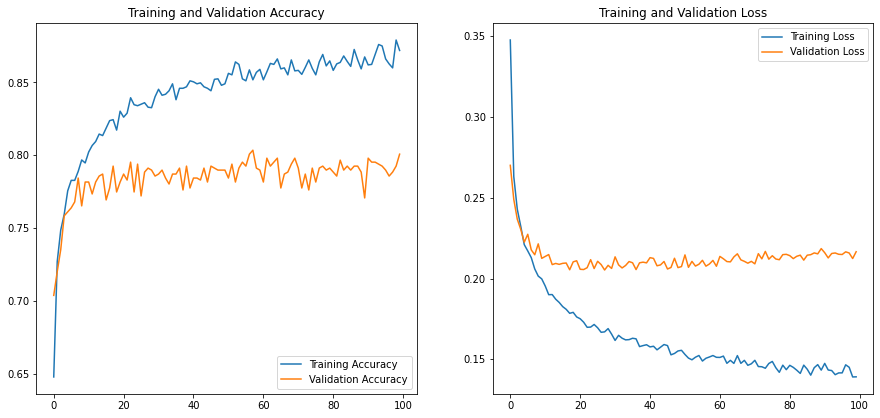

In [22]:
#plotting model 3 results
plot_results(result3,range(100))

##### Preprocessing and predicting labels for the test images

In [23]:
test_image =[]
for i in tqdm(range(test.shape[0])):
    img = image.load_img('../input/aptos2019-blindness-detection/test_images/'+test['id_code'][i]+'.png', target_size=(IMG_SIZE,IMG_SIZE,3), grayscale=False)
#     img = crop_image (img,30)
#     img = edge_Detect(img)
    img_array = image.img_to_array(img)
    img_array =img_array/255
    test_image.append(img_array)

100%|██████████| 1928/1928 [02:23<00:00, 13.40it/s]


##### Test Labels

In [31]:
X_Test = np.array(test_image)
test_predict = model.predict_classes(X_Test) #stores the test labels
test_predict

array([2, 3, 2, ..., 4, 2, 0])

Text(0.5, 1.0, 'countplot for test labels predicted using our model')

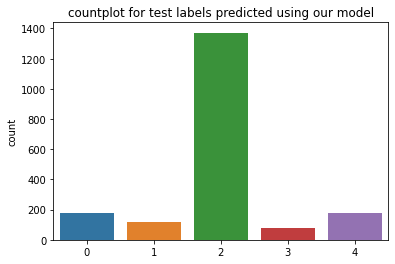

In [34]:
sns.countplot(x=test_predict)
plt.title('countplot for test labels predicted using our model')

##### Adding diagnosis labels column on test dataset

In [33]:
test['diagnosis'] = test_predict
test.head() 

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
